<a href="https://colab.research.google.com/github/1900690/yolov10/blob/main/train-yolov10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# カスタムデータセットでYOLOv10の物体検出をトレーニングする方法

---

[![arXiv](https://img.shields.io/badge/arXiv-2405.14458-b31b1b.svg)](https://arxiv.org/pdf/2405.14458.pdf)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/THU-MIG/yolov10)
[![Hugging Face Spaces](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/SkalskiP/YOLO-ARENA)

YOLOv10は、リアルタイムでエンドツーエンドの物体検出を行うYOLOシリーズの新世代です。非最大抑制（NMS）の必要性をなくし、モデル・アーキテクチャを包括的に最適化することで、YOLOの性能と効率の両方を向上させることを目的としています。この進歩により、計算量が削減され、効率と能力の両方が向上します。YOLOv10は最先端の性能と効率を示し、YOLOv10-SはRT-DETR-R18より1.8倍高速で、パラメータとFLOP数が大幅に少ない。さらに、YOLOv10-Bは、同じ性能を維持しながら、YOLOv9-Cと比較して通信の遅延時間を46%削減し、パラメータを25%削減しています。

<p align="center">
  <img src="https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov10_latency.svg" width=48%>
  <img src="https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov10_params.svg" width=48%> <br>
  計算速度-精度（左）とモデルサイズ-精度（右）のトレードオフの観点から他と比較。
</p>

##Tips: GPUを使用して計算時間の短縮を行う

Google Colabでこのノートブックを実行している場合、`ランタイム` -> `ランタイムのタイプを変更` -> `ハードウェアアクセラレータ` に移動し、`GPU`を選択し、`保存`をクリックします。これでノートブックがGPUを使用するようになり、モデルのトレーニング時間が大幅に短縮されます。


## 始める前に


In [1]:
#@markdown グーグルドライブへのアクセスを行い、重みの保存場所を確保する。また、カレントディレクトリへのパスを取得する。
#ドライブマウント
from google.colab import drive
drive.mount('/content/drive')

#カレントディレクトリの確認とインストール場所の設定
import os
HOME = os.getcwd()

Mounted at /content/drive


## YOLOv10をインストールする

In [2]:
#@markdown **注意：**現在、YOLOv10は独自のPyPIパッケージを持っていない。そのため、ソースからインストールする必要がある。
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.6 MB/s eta 0:00:00


## 訓練済み重みのダウンロード

YOLOv10は、COCOデータセットで事前にトレーニングされた重みファイルを様々なサイズで提供しています。学習に使用する重みを選択しダウンロードする。



*   YOLOv10-N：リソースが極端に制限された環境向けのナノバージョン。
*   YOLOv10-S：スピードと精度をバランスさせた小型バージョン。
*   YOLOv10-M：汎用ミディアムバージョン。
*   YOLOv10-B：精度を高めるために幅を広げたバランス・バージョン。
*   YOLOv10-L：計算リソースを増やす代わりに精度を高めた大型バージョン。
*   YOLOv10-X：最高の精度と性能を誇る特大バージョン。




In [3]:
#@title インストールする重みファイルを選択
選択 = 'YOLOv10-X' # @param ["YOLOv10-N", "YOLOv10-S", "YOLOv10-M", "YOLOv10-B", "YOLOv10-L", "YOLOv10-X"]
!mkdir -p {HOME}/weights

if 選択 == "YOLOv10-N":
  !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
if 選択 == "YOLOv10-S":
  !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
if 選択 == "YOLOv10-M":
  !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
if 選択 == "YOLOv10-B":
  !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
if 選択 == "YOLOv10-L":
  !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
if 選択 == "YOLOv10-X":
  !wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt

#fastlabelで印付き画像をエクスポートする

<p align="center">
  <img src="https://fastlabel.notion.site/image/https%3A%2F%2Ffiles.readme.io%2F0d7e2c2-_2022-06-24_16.14.37.png?table=block&id=70683ebb-9d66-43fc-a849-9dca81ca7a65&spaceId=b09acb41-4740-4d1c-87a6-4fb648f2ad1c&width=2000&userId=&cache=v2" width=80%>
 <br>
  fastlabelのエクスポートタブで'出力形式'を'YOLO'、'画像出力'を'オリジナル'を選択してエクスポートする
</p>

In [4]:
#@title エクスポートしたzipファイルをアップロード

#ライブラリをインポート(機能を使えるようにする)
import shutil
import os
from google.colab import files
import math


#すでにフォルダがある場合は消す
if os.path.exists("/content/datasets"):
  shutil.rmtree("/content/datasets")

#データをアップロード
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
#データを解凍
shutil.unpack_archive('/content/'+file_name, '/content/')
#zipを消す
os.remove('/content/'+file_name)

Saving syakuyaku-100_20240623150119.zip to syakuyaku-100_20240623150119.zip


In [5]:
#@title 画像を学習用とテスト用に分割
#ライブラリをインポート
import shutil
import os
from sklearn.model_selection import train_test_split
import math

#分割元のパスを作成
originals='/content/original'
annotations='/content/yolo/annotations'

#分割先のパスを作成
train_images = '/content/datasets/train/images'
train_labels = '/content/datasets/train/labels'
valid_images = '/content/datasets/valid/images'
valid_labels = '/content/datasets/valid/labels'

#分割先のファイルを作成
if os.path.exists('/content/datasets/'):
  shutil.rmtree('/content/datasets/')
if not os.path.exists('/content/datasets/'):
  os.makedirs(train_images)
  os.makedirs(train_labels)
  os.makedirs(valid_images)
  os.makedirs(valid_labels)


#フォルダの中のファイルのリストを作成
read_files_annotations = os.listdir(annotations)
read_files_annotations.sort()
read_files_originals= os.listdir(originals)
read_files_originals.sort()

#@markdown何％をテスト用に分割するのかを定義
分割割合=0.2#@param {type:"slider", min:0, max:1, step:0.1}

#分割割合に合わせてファイルのリストを分割
annotations_train, annotations_test, originals_train, originals_test = train_test_split(read_files_annotations,read_files_originals,test_size=分割割合)


#画像とアノテーションを分ける
for filename in annotations_train:
  shutil.copy( annotations+"/"+filename,train_labels)
for filename in annotations_test:
  shutil.copy( annotations+"/"+filename,valid_labels)
for filename in originals_train:
  shutil.copy( originals+"/"+filename,train_images)
for filename in originals_test:
  shutil.copy( originals+"/"+filename,valid_images)

#最大公約数を計算
greatest_common_divisor=math.gcd(sum(os.path.isfile(os.path.join(train_images, name)) for name in os.listdir(train_images)),sum(os.path.isfile(os.path.join(valid_images, name)) for name in os.listdir(valid_images)))

#分割されたファイル数を表示
print("train/imagesは",sum(os.path.isfile(os.path.join(train_images, name)) for name in os.listdir(train_images)),"枚")
print("train/labelsは",sum(os.path.isfile(os.path.join(train_labels, name)) for name in os.listdir(train_labels)),"枚")
print("valid/imagesは",sum(os.path.isfile(os.path.join(valid_images, name)) for name in os.listdir(valid_images)),"枚")
print("valid/labelsは",sum(os.path.isfile(os.path.join(valid_labels, name)) for name in os.listdir(valid_labels)),"枚")
print("最大公約数は",greatest_common_divisor,"<-この数はbatchを決める際に必要")

train/imagesは 102 枚
train/labelsは 102 枚
valid/imagesは 26 枚
valid/labelsは 26 枚
最大公約数は 2 <-この数はbatchを決める際に必要


#学習データに関する詳細ファイルを作成

In [6]:
#以下の★の部分を学習目的に応じて書き換える
%%writefile /content/datasets/data.yaml

#★検出する項目の数だけ-の後に項目名を記載する
names:
- flower

#★検出する項目の数を記載
nc: 1

#ここは触らない
test: ../test/images
train: ../train/images
val: ../valid/images

Writing /content/datasets/data.yaml


## 学習開始
下に書いてある項目を設定し、学習をスタートさせる


*   epochは学習回数
*   [batch](https://qiita.com/kenta1984/items/bad75a37d552510e4682#:~:text=%E3%83%87%E3%82%A3%E3%83%BC%E3%83%97%E3%83%A9%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0%E3%81%A7%E3%81%AF,%E3%83%87%E3%83%BC%E3%82%BF%E3%81%AE%E6%95%B0%E3%82%92%E3%83%90%E3%83%83%E3%83%81%E3%82%B5%E3%82%A4%E3%82%BA%E3%81%A8%E5%91%BC%E3%81%B3%E3%81%BE%E3%81%99%E3%80%82)はバッチサイズ（最大公約数に合わせることが多い）
*   plotsは学習結果を保存するかどうか（True or False）
*   imgszは学習に使う画像のサイズ
*   modelは学習に使用するモデル（yolov10n～yolov10xまでで上の部分でダウンロードした重みを記載）
*   dataはそのままで



In [8]:
%cd {HOME}

!yolo task=detect mode=train \
epochs=50 \
batch=2 \
plots=True \
imgsz=1280\
model={HOME}/weights/yolov10x.pt \
data=/content/datasets/data.yaml

/content
New https://pypi.org/project/ultralytics/8.2.39 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov10x.pt, data=/content/datasets/data.yaml, epochs=50, time=None, patience=100, batch=2, imgsz=1280, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_m

#性能確認

##confusionマトリックス
<p align="center">
  <img src="https://image.itmedia.co.jp/ait/articles/2208/08/l_di-01.gif" width=50%>
 <br>
  TPとTNの数が大きいほど性能が良い
</p>

In [14]:
#@title confusionマトリックスを表示
#@markdown 学習終了時に表示されるruns/detect/trainの後につく数を設定する。
#@markdown ※数字がない場合は１を記入してください
trainの後につく数字 = 2 # @param {type:"number"}
%cd {HOME}
from IPython.display import Image
if trainの後につく数字==1:
  Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=700)
else:
  Image(filename=f'{HOME}/runs/detect/train'+str(trainの後につく数字)+'/confusion_matrix.png', width=700)

/content


##学習の推移
重要な値は[metrics/mAP50](https://medium.com/axinc/map-%E7%89%A9%E4%BD%93%E6%A4%9C%E5%87%BA%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E8%A9%95%E4%BE%A1%E6%8C%87%E6%A8%99-956a786e8c3d#:~:text=AP%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6,%E3%81%AB%E3%81%AA%E3%82%8A%E3%81%BE%E3%81%99%E3%80%82)と[metrics/mAP50-90](https://docs.ultralytics.com/ja/guides/yolo-performance-metrics/#:~:text=mAP50%2D95%3A%200.50%E3%81%8B%E3%82%890.95%E3%81%BE%E3%81%A7%E3%81%AE%E6%A7%98%E3%80%85%E3%81%AAIoU%E9%96%BE%E5%80%A4%E3%81%A7%E8%A8%88%E7%AE%97%E3%81%95%E3%82%8C%E3%81%9F%E5%B9%B3%E5%9D%87%E5%B9%B3%E5%9D%87%E7%B2%BE%E5%BA%A6%E3%80%82%E7%95%B0%E3%81%AA%E3%82%8B%E6%A4%9C%E5%87%BA%E9%9B%A3%E6%98%93%E5%BA%A6%E3%81%AB%E3%81%8A%E3%81%91%E3%82%8B%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E3%83%91%E3%83%95%E3%82%A9%E3%83%BC%E3%83%9E%E3%83%B3%E3%82%B9%E3%82%92%E5%8C%85%E6%8B%AC%E7%9A%84%E3%81%AB%E8%A6%8B%E3%82%8B%E3%81%93%E3%81%A8%E3%81%8C%E3%81%A7%E3%81%8D%E3%82%8B%E3%80%82)この二つが１に近いほど性能が良い

*   [metorics/recall(B)](https://medium.com/axinc/map-%E7%89%A9%E4%BD%93%E6%A4%9C%E5%87%BA%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E8%A9%95%E4%BE%A1%E6%8C%87%E6%A8%99-956a786e8c3d#:~:text=Precision%E3%81%AF%E6%A4%9C%E5%87%BA%E3%81%97%E3%81%9F%E3%83%90%E3%82%A6%E3%83%B3%E3%83%87%E3%82%A3%E3%83%B3%E3%82%B0%E3%83%9C%E3%83%83%E3%82%AF%E3%82%B9%E3%81%8C%E6%AD%A3%E3%81%97%E3%81%84%E6%AF%94%E7%8E%87%E3%82%92%E7%A4%BA%E3%81%97%E3%81%BE%E3%81%99%E3%80%82%E9%96%93%E9%81%95%E3%81%A3%E3%81%9F%E3%83%90%E3%82%A6%E3%83%B3%E3%83%87%E3%82%A3%E3%83%B3%E3%82%B0%E3%83%9C%E3%83%83%E3%82%AF%E3%82%B9%E3%82%92%E9%81%8E%E5%89%B0%E3%81%AB%E6%A4%9C%E5%87%BA%E3%81%97%E3%81%A6%E3%81%97%E3%81%BE%E3%81%86%E9%81%8E%E6%A4%9C%E5%87%BA%E3%81%8C%E3%81%AA%E3%81%91%E3%82%8C%E3%81%B01.0%E3%81%AB%E3%81%AA%E3%82%8A%E3%81%BE%E3%81%99%E3%80%82%E3%81%9F%E3%81%A0%E3%81%97%E3%80%81%E6%A4%9C%E5%87%BA%E3%81%99%E3%81%B9%E3%81%8D%E3%83%90%E3%82%A6%E3%83%B3%E3%83%87%E3%82%A3%E3%83%B3%E3%82%B0%E3%83%9C%E3%83%83%E3%82%AF%E3%82%B9%E3%82%92%E6%A4%9C%E5%87%BA%E3%81%A7%E3%81%8D%E3%81%A6%E3%81%84%E3%81%AA%E3%81%84%E3%80%81%E6%9C%AA%E6%A4%9C%E5%87%BA%E3%81%8C%E3%81%82%E3%81%A3%E3%81%A6%E3%82%821.0%E3%81%AB%E3%81%AA%E3%82%8A%E3%81%BE%E3%81%99%E3%80%82):検出したバウンディングボックスが正しい比率
*   [metorics/presicion(B)](https://medium.com/axinc/map-%E7%89%A9%E4%BD%93%E6%A4%9C%E5%87%BA%E3%83%A2%E3%83%87%E3%83%AB%E3%81%AE%E8%A9%95%E4%BE%A1%E6%8C%87%E6%A8%99-956a786e8c3d#:~:text=Recall%E3%81%AF%E6%A4%9C%E5%87%BA%E3%81%99%E3%81%B9%E3%81%8D%E3%83%90%E3%82%A6%E3%83%B3%E3%83%87%E3%82%A3%E3%83%B3%E3%82%B0%E3%83%9C%E3%83%83%E3%82%AF%E3%82%B9%E3%82%92%E6%A4%9C%E5%87%BA%E3%81%A7%E3%81%8D%E3%81%A6%E3%81%84%E3%82%8B%E6%AF%94%E7%8E%87%E3%82%92%E7%A4%BA%E3%81%97%E3%81%BE%E3%81%99%E3%80%82%E6%A4%9C%E5%87%BA%E3%81%99%E3%81%B9%E3%81%8D%E3%83%90%E3%82%A6%E3%83%B3%E3%83%87%E3%82%A3%E3%83%B3%E3%82%B0%E3%83%9C%E3%83%83%E3%82%AF%E3%82%B9%E3%82%92%E6%A4%9C%E5%87%BA%E3%81%A7%E3%81%8D%E3%81%A6%E3%81%84%E3%81%AA%E3%81%84%E6%9C%AA%E6%A4%9C%E5%87%BA%E3%81%8C%E3%81%AA%E3%81%91%E3%82%8C%E3%81%B01.0%E3%81%AB%E3%81%AA%E3%82%8A%E3%81%BE%E3%81%99%E3%80%82%E3%81%9F%E3%81%A0%E3%81%97%E3%80%81%E9%96%93%E9%81%95%E3%81%A3%E3%81%9F%E3%83%90%E3%82%A6%E3%83%B3%E3%83%87%E3%82%A3%E3%83%B3%E3%82%B0%E3%83%9C%E3%83%83%E3%82%AF%E3%82%B9%E3%82%92%E9%81%8E%E5%89%B0%E3%81%AB%E6%A4%9C%E5%87%BA%E3%81%97%E3%81%A6%E3%81%97%E3%81%BE%E3%81%86%E9%81%8E%E6%A4%9C%E5%87%BA%E3%81%8C%E3%81%82%E3%81%A3%E3%81%A6%E3%82%821.0%E3%81%AB%E3%81%AA%E3%82%8A%E3%81%BE%E3%81%99%E3%80%82):検出すべきバウンディングボックスを検出できている比率



/content


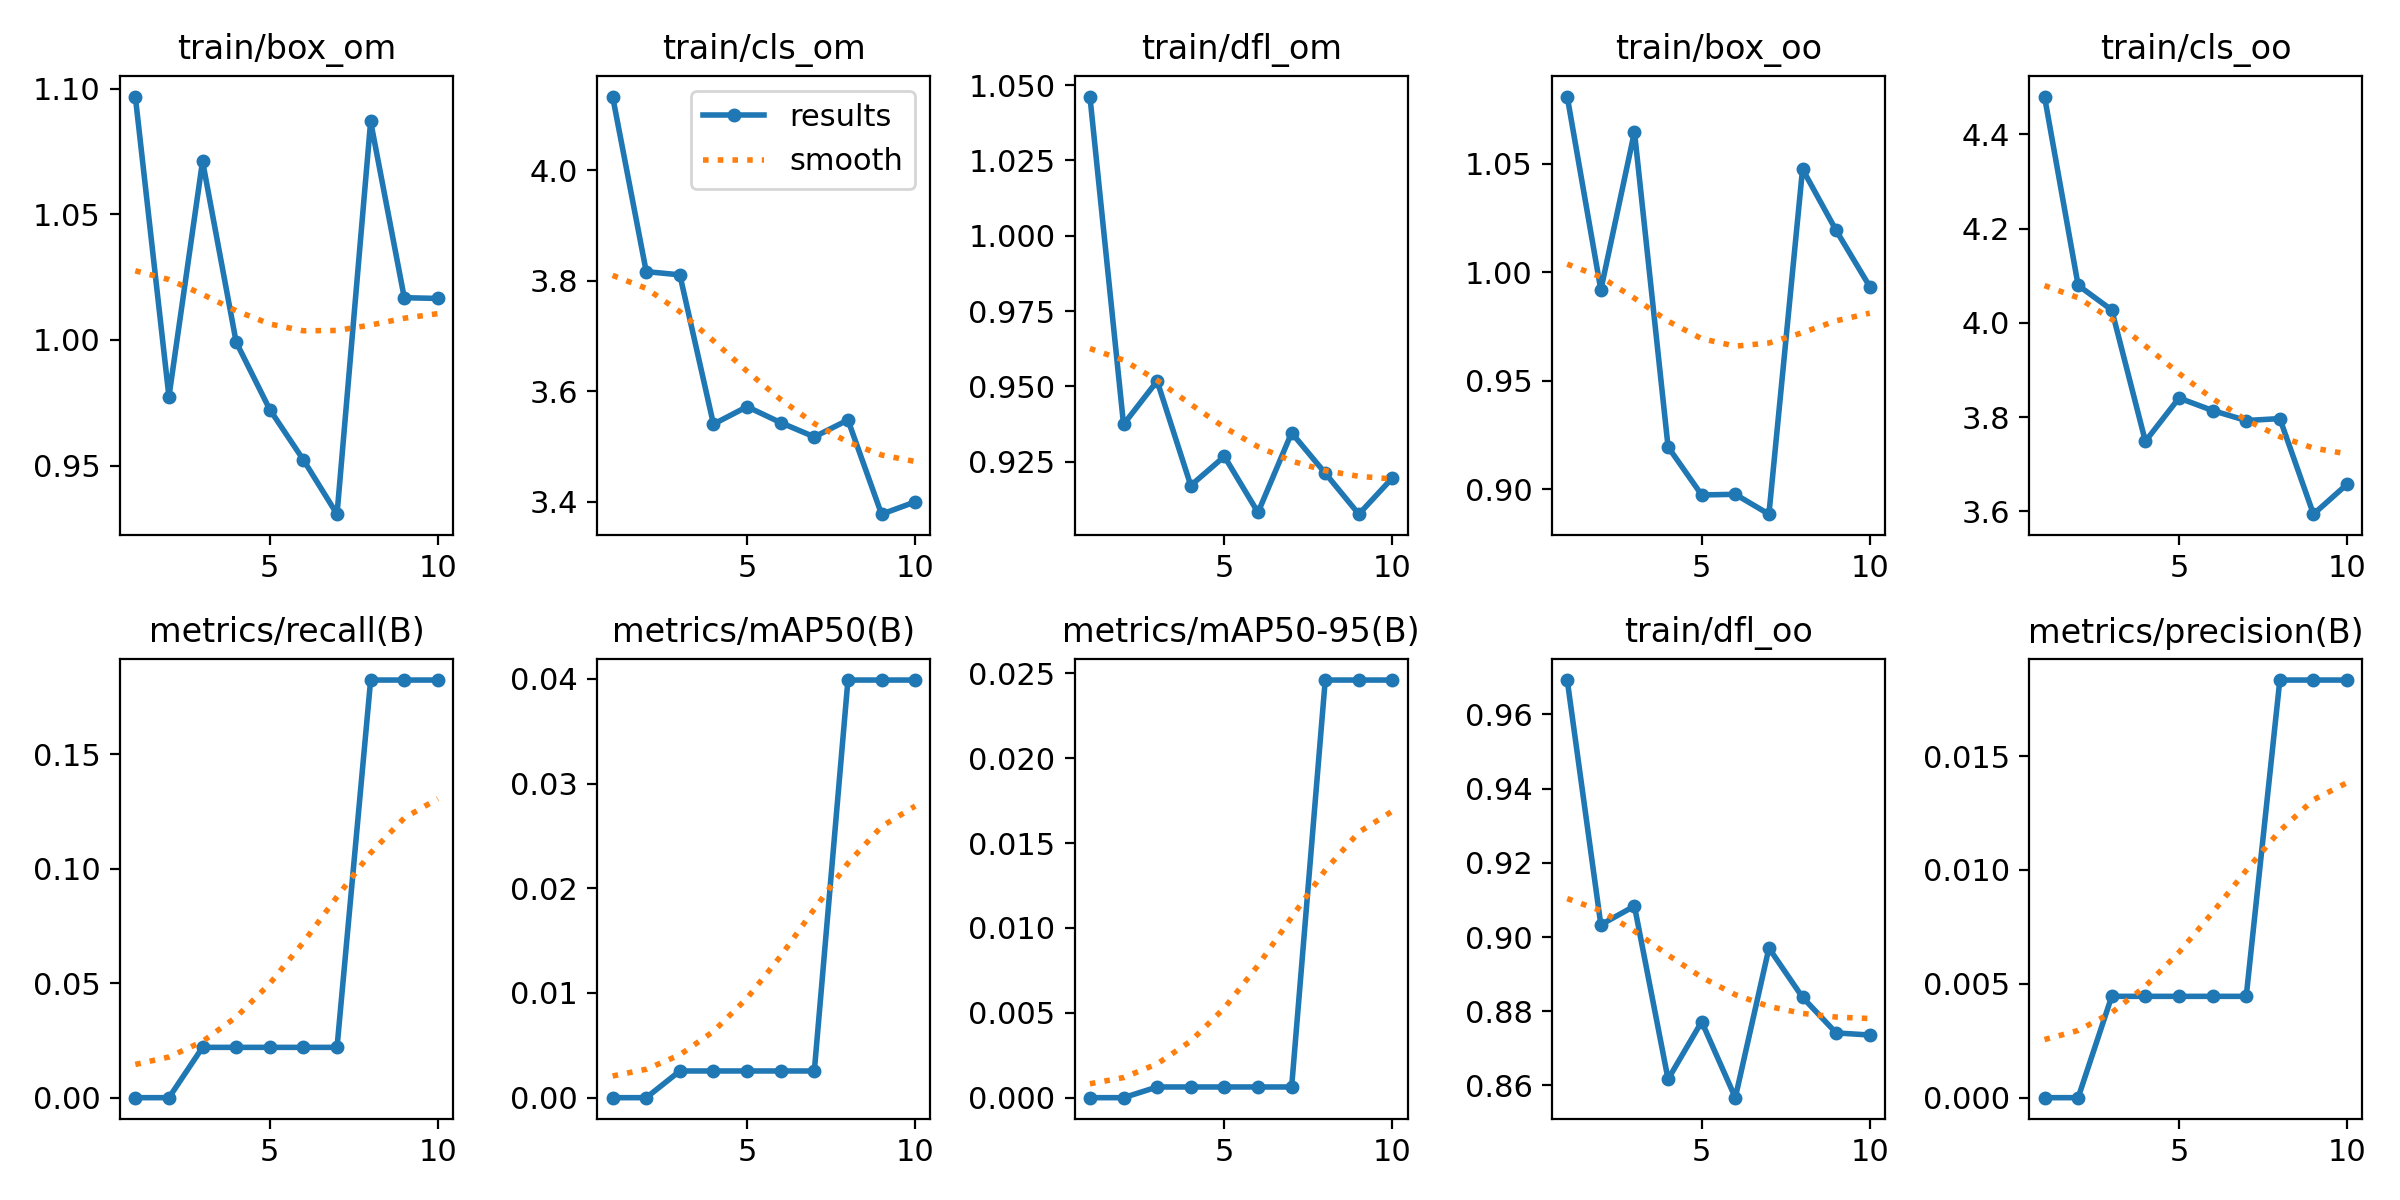

In [ ]:
#@title 学習の推移を表示

#@markdown 学習終了時に表示されるruns/detect/trainの後につく数を設定する。
#@markdown ※数字がない場合は１を記入してください

trainの後につく数字 = 1 # @param {type:"number"}
%cd {HOME}
from IPython.display import Image
if trainの後につく数字==1:
  Image(filename=f'{HOME}/runs/detect/train/results.png', width=700)
else:
  Image(filename=f'{HOME}/runs/detect/train'+str(trainの後につく数字)+'/results.png', width=700)

In [ ]:
#@title **注意**：学習が終了したら、重みをdriveのフォルダに移しておくこと、タブを消去すると計算結果がすべて消える

#@markdown 学習終了時に表示されるruns/detect/trainの後につく数を設定してdriveへ重みを移動
trainの後につく数字 = 2 # @param {type:"number"}

#グーグルドライブにコピー
%cd {HOME}
from IPython.display import Image
if trainの後につく数字==1:
  shutil.copyfile("/content/runs/detect/train/weights/best.pt","/content/drive/MyDrive/best.pt")
else:
  shutil.copyfile("/content/runs/detect/train"+str(trainの後につく数字)+"/weights/best.pt","/content/drive/MyDrive/best"+str(trainの後につく数字)+".pt")

# 学習したAIによる推論

In [ ]:
#@markdown グーグルドライブへのアクセスを行い重みへアクセスするまた、カレントディレクトリへのパスを取得する。
#ドライブマウント
from google.colab import drive
drive.mount('/content/drive')

#カレントディレクトリの確認とインストール場所の設定
import os
HOME = os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@markdown **注意：**現在、YOLOv10は独自のPyPIパッケージを持っていない。そのため、ソースからインストールする必要がある。
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 66.1 MB/s eta 0:00:00


In [ ]:
#@title 検出したい画像を圧縮したzipファイルをアップロード

#ライブラリをインポート(機能を使えるようにする)
import shutil
import os
from google.colab import files
import math


#すでにフォルダがある場合は消す
if os.path.exists("/content/predict_sets"):
  shutil.rmtree("/content/predict_sets")

if not os.path.exists('/content/predict_sets/'):
  os.makedirs('/content/predict_sets/')

#データをアップロード
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
#データを解凍
shutil.unpack_archive('/content/'+file_name, '/content/predict_sets/')
#zipを消す
os.remove('/content/'+file_name)

Saving TLC00009_119.zip to TLC00009_119.zip


## 推論開始
下に書いてある項目を設定し、推論をスタートさせる


*   modelには学習した重みまでのパスを設定する
*   confは確度が何％になったら枠を表示するのか
*   imgszは推論に使う画像のサイズ
*   show_confは確度を表示するかどうか
*   save_txtは枠の座標を記録するかどうか（必ずTrueにすること）
*   deviceはGPUを使うかどうか（そのままで）
*   sourceは推論する画像のフォルダまでのパス（そのままで）

In [ ]:
%cd {HOME}

!yolo task=detect \
      mode=predict \
      model= /content/drive/MyDrive/best.pt\
      conf=0.4 \
      imgsz=1280\
      show_conf=False \
      save_txt=True \
      device=0\
      source="/content/predict_sets/"

/content
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10x summary (fused): 503 layers, 31591784 parameters, 0 gradients, 169.8 GFLOPs

image 1/21 /content/predict_sets/TLC00009_023.jpg: 736x1280 2 0s, 54 1s, 13 2s, 107.3ms
image 2/21 /content/predict_sets/TLC00009_047.jpg: 736x1280 1 0, 60 1s, 18 2s, 101.4ms
image 3/21 /content/predict_sets/TLC00009_071.jpg: 736x1280 1 0, 58 1s, 18 2s, 1 3, 100.9ms
image 4/21 /content/predict_sets/TLC00009_095.jpg: 736x1280 48 1s, 20 2s, 101.3ms
image 5/21 /content/predict_sets/TLC00009_119.jpg: 736x1280 48 1s, 54 2s, 3 3s, 102.1ms
image 6/21 /content/predict_sets/TLC00009_143.jpg: 736x1280 45 1s, 61 2s, 2 3s, 101.1ms
image 7/21 /content/predict_sets/TLC00009_167.jpg: 736x1280 40 1s, 65 2s, 7 3s, 100.9ms
image 8/21 /content/predict_sets/TLC00009_191.jpg: 736x1280 44 1s, 72 2s, 7 3s, 102.3ms
image 9/21 /content/predict_sets/TLC00009_215.jpg: 736x1280 36 1s, 65 2s, 6 3s, 101.3ms
image 10/21 /content/predict_

##classes.txtを作成

In [ ]:
#classes.txtを入れる場所を作成
if not os.path.exists('/content/predict/'):
  os.makedirs('/content/predict/')

In [ ]:
#★%%writefileから下の部分をアノテーションクラスに応じて書き換える
%%writefile /content/predict/classes.txt
0
1
2
3

Writing /content/predict/classes.txt


In [ ]:
#@title アノテーションファイルを作成してダウンロード
#@markdown 検出終了時に表示されるruns/detect/predictの後につく数を設定してアノテーションファイルを作成
#@markdown ※数字がない場合は１を記入してください
import shutil
import os
from google.colab import files

predictの後につく数字 = 1 # @param {type:"number"}

#すでにフォルダがある場合は消す
if os.path.exists("/content/predict/annotations"):
  shutil.rmtree("/content/predict/annotations")
if not os.path.exists('/content/predict/annotations/'):
  os.makedirs('/content/predict/annotations/')
if predictの後につく数字==1:
  shutil.copytree("/content/runs/detect/predict/labels", "/content/predict/annotations/", dirs_exist_ok=True)
else:
  shutil.copytree("/content/runs/detect/predict"+str(predictの後につく数字)+"/labels", "/content/predict/annotations/", dirs_exist_ok=True)

#圧縮
shutil.make_archive('/content/predict', format='zip', root_dir='/content/predict')
#ダウンロード
files.download("/content/predict.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#追跡機能付き推論

In [ ]:
#ライブラリインポート
import cv2
import torch
import datetime
import numpy as np
from absl import app, flags
from absl.flags import FLAGS
#from ultralytics import YOLOv10
from deep_sort_realtime.deepsort_tracker import DeepSort
from IPython.display import HTML
from base64 import b64encode

#AVI->mp4動画変換
def convert_avi_to_mp4(file_path):
    #VideoCaptureオブジェクトを取得
    cap = cv2.VideoCapture(file_path)

    #動画のプロパティを取得
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    #書き出し設定
    fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
    writer = cv2.VideoWriter("/content/mp4/"+os.path.splitext(os.path.basename(file_path))[0]+".mp4", fourcc, fps, (width, height))

    while True:
        ret, frame = cap.read()
        writer.write(frame)
        if not ret:
            break

    writer.release()
    cap.release()

#動画表示用関数定義
def play_video(filename):
  html = ''
  video = open(filename,'rb').read()
  src = 'data:video/mp4;base64,' + b64encode(video).decode()
  html += fr'<video width=900 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src
  return HTML(html)

In [ ]:
#動画と重みを定義して推論
!yolo tracker="bytetrack.yaml"\
      mode=track\
      model='/content/drive/MyDrive/best.pt'\
      conf=0.25\
      save_txt=True\
      show_conf=False\
      device=0\
      source="/content/drive/MyDrive/ColabNotebooks/test.mp4"

In [ ]:
#AVIからmp4に変換
import cv2
import os

#この中の動画が画像変換される
file_path='/content/AVI/'

#mp4フォルダを作成
if not os.path.exists('/content/mp4'):
    os.mkdir('/content/mp4')

load_name = os.listdir(file_path)

for file_name in load_name:
  convert_avi_to_mp4(file_path+file_name)

In [ ]:
#動画プレイヤーで表示
#-iの後のパスを推論済み動画のパスに変更
!ffmpeg -hide_banner -loglevel error -i /content/output.mp4 -vcodec libx264 /content/output_test.mp4 -y
play_video("/content/output_test.mp4")